Install SQL packages:

In [1]:
# !conda install -y psycopg2
# !conda install -y postgresql
# !pip install ipython-sql
# !pip install sqlalchemy

Standard imports + sqlalchemy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy

%matplotlib inline
%load_ext sql

Establish a database connection to the Postgres database running on my machine `localhost` using the schema `ds100`

In [3]:
postgresql_uri = "postgres://jegonzal:@localhost:5432/ds100"

In [4]:
%sql $postgresql_uri

'Connected: jegonzal@ds100'

Note that we don't need to specify the database URI with each `%%sql` command.  If one is not provided that the previous connection is used.  

In [5]:
%%sql 

-- Drop the table if it already exists
DROP TABLE IF EXISTS students;

-- Create the table students
CREATE TABLE students(
    name TEXT PRIMARY KEY, 
    gpa FLOAT CHECK (gpa >= 0.0 and gpa <= 4.0), 
    age INTEGER, 
    dept TEXT, 
    gender CHAR);

-- Populate the table of students
INSERT INTO students VALUES 
 ('Sergey Brin', 2.8, 40, 'CS', 'M'),
  ('Danah Boyd', 3.9, 35, 'CS', 'F'),
  ('Bill Gates', 1.0, 60, 'CS', 'M'),
  ('Hillary Mason', 4.0, 35, 'DATASCI', 'F'),
  ('Mike Olson', 3.7, 50, 'CS', 'M'),
  ('Mark Zuckerberg', 4.0, 30, 'CS', 'M'),
  ('Cheryl Sandberg', 4.0, 47, 'BUSINESS', 'F'),
  ('Susan Wojcicki', 4.0, 46, 'BUSINESS', 'F'),
  ('Marissa Meyer', 4.0, 45, 'BUSINESS', 'F');


Done.
Done.
9 rows affected.


[]

# Data Generation

It is often assumed that when working with a database all relations (tables) must come from outside or be derived from other sources of data.  It is possible to construct tables in SQL.

Sometimes it's useful to auto-generate data in queries, rather than examine data in the database. This is nice for testing, but also can be useful to play some computational tricks as you'll see in your homework.

SQL has a simple scalar function called [`random`](https://www.postgresql.org/docs/9.6/static/functions-math.html#FUNCTIONS-MATH-RANDOM-TABLE) that returns a random value between 0.0 and 1.0. You can use this if you need to generate a column of random numbers.  (The PostgreSQL manual doesn't promise much about the statistical properties of this random number generator.)

Let's roll a 6-sided die for each of the students

In [6]:
%%sql 

SELECT *, ROUND(RANDOM() * 6) as roll_dice 
FROM students;

9 rows affected.


name,gpa,age,dept,gender,roll_dice
Sergey Brin,2.8,40,CS,M,3.0
Danah Boyd,3.9,35,CS,F,2.0
Bill Gates,1.0,60,CS,M,2.0
Hillary Mason,4.0,35,DATASCI,F,3.0
Mike Olson,3.7,50,CS,M,3.0
Mark Zuckerberg,4.0,30,CS,M,6.0
Cheryl Sandberg,4.0,47,BUSINESS,F,2.0
Susan Wojcicki,4.0,46,BUSINESS,F,1.0
Marissa Meyer,4.0,45,BUSINESS,F,3.0


**Is this a good implementation of a fair 6 sided die?**

```sql
SELECT *, ROUND(RANDOM() * 6) as roll_dice 
FROM students;
```

Quiz:
___
<big>http://bit.ly/ds100nodice</big>
___

Suppose we want to generate a whole bunch of random numbers, not tied to any particular stored table -- can we do that in SQL?

SQL has a notion of [table-valued functions](https://www.postgresql.org/docs/9.6/static/functions-srf.html): functions that return tables, and hence can be used in a `FROM` clause of a query. The standard table-valued function is called `generate_series`, and it's much like numpy's `arange`:

In [7]:
%%sql 

SELECT * 
FROM GENERATE_SERIES(1, 5);

5 rows affected.


generate_series
1
2
3
4
5


In [8]:
%%sql 

SELECT * 
FROM GENERATE_SERIES(1, 10, 2);


5 rows affected.


generate_series
1
3
5
7
9


Let's test the distribution of our earlier generator:

In [9]:
%%sql 


SELECT ROUND(6*RANDOM()) AS rando, COUNT(*)
FROM GENERATE_SERIES(1, 100000) AS flip(trial)
GROUP BY rando
ORDER BY count



7 rows affected.


rando,count
6.0,8239
0.0,8527
1.0,16545
4.0,16599
3.0,16636
5.0,16644
2.0,16810


And if we want integers, we can use a PostgreSQL typecast operator (postfix `::<type>`):

In [10]:
%%sql 

-- NOTE WE ALSO TAKE THE CEIL
-- What would happen if we did not?

SELECT CEIL(6*RANDOM())::INTEGER AS rando, COUNT(*)
FROM generate_series(1, 100000) AS flip(trial)
GROUP BY rando
ORDER BY count



6 rows affected.


rando,count
2,16543
3,16602
5,16639
1,16663
4,16666
6,16887


# Making a Random Matrix in SQL?!

Now suppose we want to populate a "matrix" relation `my_matrix(r, c, v)` full of random values. Consider the following numpy code

In [11]:
import numpy as np
np.random.seed(43)
# normally distributed random numbers, mean 0 variance 1
my_matrix = np.random.randint(1,6, (3,2)).astype('float')
my_matrix

array([[ 5.,  1.],
       [ 2.,  3.],
       [ 1.,  4.]])

## Saving a Matrix as a table

How could we store the above matrix as a table?

1. A table with 3 rows and 2 columns
1. A table with 9 rows and 3 columns (how?)

Building the table in Numpy

In [12]:
my_matrix.flatten()

array([ 5.,  1.,  2.,  3.,  1.,  4.])

In [13]:
# Advanced numpy (you don't need to know this ...)
(col_id, row_id) = np.meshgrid(np.arange(2), np.arange(3))

mat_a = pd.DataFrame(
    np.vstack([row_id.flatten().T, col_id.flatten(), my_matrix.flatten()]).T, 
    columns=['r', 'c', 'v'])

mat_a

,r,c,v
0,0.0,0.0,5.0
1,0.0,1.0,1.0
2,1.0,0.0,2.0
3,1.0,1.0,3.0
4,2.0,0.0,1.0
5,2.0,1.0,4.0


In [14]:
%%sql

select * from mat_A

6 rows affected.


r,c,v
0.0,0.0,5.0
0.0,1.0,1.0
1.0,0.0,2.0
1.0,1.0,3.0
2.0,0.0,1.0
2.0,1.0,4.0


In [15]:
engine = sqlalchemy.create_engine(postgresql_uri)
with engine.connect() as conn:
    conn.execute("DROP TABLE IF EXISTS mat_a")
    mat_a.to_sql("mat_a", conn, index=False)

In [16]:
%%sql

SELECT * FROM mat_a

6 rows affected.


r,c,v
0.0,0.0,5.0
0.0,1.0,1.0
1.0,0.0,2.0
1.0,1.0,3.0
2.0,0.0,1.0
2.0,1.0,4.0


In this relational version we need to explicitly generate the `r` and `c` values. We can do this via SQL's built-in cartesian product!

In [17]:
%%sql 

SELECT rows.r, columns.c, CEIL(6*RANDOM())::INTEGER AS v
  FROM generate_series(0,2) AS rows(r),
       generate_series(0,1) AS columns(c);

6 rows affected.


r,c,v
0,0,4
0,1,1
1,0,5
1,1,3
2,0,5
2,1,3


We may want to store a matrix as a table—in which case we should set up the schema properly to ensure that it remains a legal matrix.

In [18]:
%%sql 

DROP TABLE IF EXISTS my_matrix;

CREATE TABLE my_matrix(r INTEGER, c INTEGER, val FLOAT, PRIMARY KEY(r, c));

INSERT INTO my_matrix
SELECT rows.r, columns.c, CEIL(6*RANDOM())::INTEGER AS v
  FROM generate_series(0,2) AS rows(r),
       generate_series(0,1) AS columns(c);        

Done.
Done.
6 rows affected.


[]

In [19]:
%%sql 

SELECT * FROM my_matrix;

6 rows affected.


r,c,val
0,0,5.0
0,1,1.0
1,0,3.0
1,1,6.0
2,0,3.0
2,1,3.0


A few take-aways from the previous cell:
- Notice the schema of `my_matrix` reflects the fact that `val` is a function of the row (`x`) and column (`y`) IDs.
- We've said before that the order of rows in a table isn't defined in SQL. Is this relational representation of a "matrix" faithful to the mathematical definition of a matrix? Why or why not?
- Notice the `INSERT` statement, which contains a `SELECT` query rather than the `VALUES` we saw before. You might want to experiment and see what would happen if the `SELECT` query produces a different schema than `my_matrix`: try having it produce too few columns, too many columns, columns in different orders, etc.
- In the `INSERT...SELECT` statement, notice the definition of output column names via the `AS` in the `SELECT` clause. Is that necessary here?
- In the `INSERT...SELECT` statement, notice the definition of table *and* column names in the `FROM` clause via `AS`, and the way they get referenced in the `SELECT` clause. Do we need the tablenames specified in the `SELECT` clause? Try it and see!
- Count the rows in the output...does it look good?


### User-defined functions (UDFs)
Sometimes we may want a custom scalar function that isn't built into SQL. Some database systems allow you to register your own *user-defined functions* (UDFs) in one or more programming languages. Conveniently, PostgreSQL allows us to register user-defined functions written in Python. Be aware of two things:

1. Calling Python for each row in a query is quite a bit slower than using the pre-compiled built-in functions in SQL ... this is akin to the use of Python loops instead of `numpy` calls. *If you can avoid using Python UDFs you should do so to get better performance*.

2. Python is a full-feature programming language with access to your operating system's functionality, which means it can reach outside of the scope of the query and wreak havoc, including running arbitrary UNIX commands. (PostgreSQL refers to this as an `untrusted` language.) Be *very* careful with the Python UDFs you use in your Postgres queries! If you want to be safer write UDFs in a trusted language. PostgreSQL has a [number of other languages](https://www.postgresql.org/docs/current/static/xplang.html) to choose from, including [Java](https://www.postgresql.org/docs/current/static/external-pl.html) and even [R](https://www.postgresql.org/docs/current/static/external-pl.html)!.

First we tell PostgreSQL we want to use the plpythonu package (so named because of "pl" for "programming language", "u" for "untrusted"):

In [20]:
%%sql 

CREATE EXTENSION IF NOT EXISTS plpythonu;

Done.


[]

Now let's write some trivial Python code and register it as a UDF using the `create function` command. Since SQL is a typed language, we need to specify the SQL types for the input and output to our function, in addition to the code (within $$ delimiters) and the language:

In [21]:
%%sql 

DROP FUNCTION IF EXISTS fib(x INTEGER);

CREATE FUNCTION fib(x INTEGER) RETURNS INTEGER
AS $$
def fib(x):
    if x < 2:
        return x
    else:
        return fib(x-1) + fib(x-2)
return fib(x)
$$ LANGUAGE plpythonu;

Done.
Done.


[]

In [22]:
%%sql $postgresql_uri

SELECT x, fib(x)
FROM generate_series(1,10) AS row(x);

10 rows affected.


x,fib
1,1
2,1
3,2
4,3
5,5
6,8
7,13
8,21
9,34
10,55


# A Discussion on Transactions

It is possible to create transactions that isolate changes.  This is done by starting a transaction with `BEGIN`.  We can then proceed to make changes to the database.  During this time others will not be able to see our changes. Until we end the transactions by saying `ROLLBACK` or `COMMIT`:

```sql
BEGIN;

UPDATE students SET gpa = 3.0 WHERE name = 'Bill Gates'; 

SELECT * FROM students;

ROLLBACK;

SELECT * FROM students;
```

Try running this in the postgres shell...



#  Descriptive Statistics in SQL


Statistics doesn't deal with individuals, it deals with groups: distributions, populations, samples and the like. As such, computing statistics in SQL focuses heavily on aggregation functions.

All SQL systems have simple descriptive statistics built in as aggregation functions:
- `min, max`
- `count`
- `sum`
- `avg`
- `stddev` and `variance`, the sample standard deviation and variance.

PostgreSQL offers [many more](https://www.postgresql.org/docs/current/static/functions-aggregate.html#FUNCTIONS-AGGREGATE-STATISTICS-TABLE). Some handy ones include
- `stddev_pop` and `var_pop`: the population standard deviation and variance, which you should use rather than `stddev` and `variance` if you know your data is the full population, not a sample.
- `covar_samp` and `covar_pop`: sample and population covariance
- `corr`, Pearson's correlation coefficient


## Order Statistics: Aggregates requiring ordered input
You'll notice that a number of handy statistics are missing from this list, including the median and quartiles. That's because those are [order statistics](https://en.wikipedia.org/wiki/Order_statistic): they are defined based on an ordering of the values in a column. 

SQL provides for this by allowing what it calls "ordered set functions", which require a `WITHIN GROUP (ORDER BY <columns>)` clause to accompany the order-statistic aggregate.  For example, to compute the 25th percentile, 50th percentile (median) and 75th percentile in SQL, we can use the following:

In [23]:
%%sql 

SELECT 
    percentile_cont(0.5) WITHIN GROUP (ORDER BY x) 
FROM generate_series(1,10) AS data(x);

1 rows affected.


percentile_cont
5.5


There are two versions of the percentile function:
* **`percentile_cont`** inuous : interpolates
* **`percentile_disc`** rete : returns an entry from the table

What will the following expressions return?

In [24]:
%%sql $postgresql_uri

SELECT 
    percentile_disc(0.5) WITHIN GROUP (ORDER BY x) 
FROM generate_series(1,10) AS data(x);

1 rows affected.


percentile_disc
5


We can compute the edges and middle of the box in a box plot:

In [25]:
%%sql $postgresql_uri
SELECT 
    percentile_disc(0.25) WITHIN GROUP (ORDER BY x) as lower_quartile,
    percentile_disc(0.5) WITHIN GROUP (ORDER BY x) as median,
    percentile_disc(0.75) WITHIN GROUP (ORDER BY x) as upper_quartile
FROM generate_series(1,10) AS data(x);

1 rows affected.


lower_quartile,median,upper_quartile
3,5,8


# Working with Real Data in `psql`
In a separate notebook (`load_fec.ipynb`) you'll find the commands to load publicly-available campaign finance [data from the Federal Election Commission](http://www.fec.gov/finance/disclosure/ftpdet.shtml#a2015_2016) into a PostgreSQL database.

To see what we have in the database, it's simplest to use the PostgreSQL shell command `psql` to interact with the database.  You can run `man psql` to learn more about it. A few handy tips:
1. `psql` supports some useful non-SQL "meta-"commands, which you access via backslash (`\`). To find out about them, run `psql` in a bash shell, and at the prompt you can type `\?`.
2. `psql` has builtin documentation for SQL. To see that, at the `psql` prompt type `\help`.
3. `psql` is an interactive SQL shell, so not suitable for use inside a Jupyter notebook. If you want to invoke it within a Jupyter notebook, you should use `!psql -c <SQL statement>` -- the `-c` flag tells psql to run the SQL statement and then exit:

Let's see what tables we have our database after loading the FEC data:

In [26]:
!psql ds100 -c "\d"

             List of relations
 Schema |     Name      | Type  |  Owner   
--------+---------------+-------+----------
 public | boats         | table | jegonzal
 public | ccl           | table | jegonzal
 public | cm            | table | jegonzal
 public | cn            | table | jegonzal
 public | date_stats    | view  | jegonzal
 public | indiv_sample  | table | jegonzal
 public | indiv_sample2 | table | jegonzal
 public | individual    | table | jegonzal
 public | mat_a         | table | jegonzal
 public | my_matrix     | table | jegonzal
 public | oppexp        | table | jegonzal
 public | pas           | table | jegonzal
 public | profs         | table | jegonzal
 public | rando         | view  | jegonzal
 public | reserves      | table | jegonzal
 public | sailors       | table | jegonzal
 public | students      | table | jegonzal
 public | tips          | table | jegonzal
(18 rows)



And let's have a look at the `individual` table's schema:

In [27]:
!psql ds100 -c "\d individual"

              Table "public.individual"
     Column      |         Type          | Modifiers 
-----------------+-----------------------+-----------
 cmte_id         | character varying(9)  | 
 amndt_ind       | character(1)          | 
 rpt_tp          | character varying(3)  | 
 transaction_pgi | character(5)          | 
 image_num       | bigint                | 
 transaction_tp  | character varying(3)  | 
 entity_tp       | character varying(3)  | 
 name            | text                  | 
 city            | text                  | 
 state           | character(2)          | 
 zip_code        | character varying(12) | 
 employer        | text                  | 
 occupation      | text                  | 
 transaction_dt  | character varying(9)  | 
 transaction_amt | integer               | 
 other_id        | text                  | 
 tran_id         | text                  | 
 file_num        | bigint                | 
 memo_cd         | text                  | 
 memo_text      

If you are curious about the meaning of these columns check out the [FEC data description](http://classic.fec.gov/finance/disclosure/metadata/DataDictionaryContributionsbyIndividuals.shtml)

How big is this table?

In [28]:
%%sql 

SELECT COUNT(*)
FROM individual 

1 rows affected.


count
20347829


# Browsing Tables: `LIMIT` and sampling
*This is not the first topic usually taught in SQL, but it's extremely useful for exploration.*

OK, now we have some serious data loaded and we're ready to explore it.

Database tables are often big--hence the use of a database system. When browsing them at first, we may want to look at exemplary rows: e.g., an arbitrary number of rows, or a random sample of the rows.

To look at all of the data in the `individual` table, we would simply write:

```sql
select * from individual;
```

But that would return ** *20,347,829* ** rows into our Jupyter notebook's memory, and perhaps overflow the RAM in your computer.  Instead, we could limit the size of the output to the first 3 rows as follows:

In [29]:
%%sql 

SELECT *
FROM individual 
LIMIT 4;

4 rows affected.


cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
C00004606,N,M4,P,15951124869,15,IND,"ARNOLD, ROBERT",MCPHERSON,KS,67460,SELF,OPTOMETRIST,03102015,1000,None,SA11AI.20747,1002259,None,None,4041320151241796098
C00004606,N,M4,P,15951124869,15,IND,"BICKLE, DON",HAYS,KS,67601,RETIRED,RETIRED,03302015,1000,None,SA11AI.20772,1002259,None,None,4041320151241796099
C00004606,N,M4,P,15951124869,15,IND,"ROSSMAN, RICHARD",OLATHE,KS,66051,CRAWFORD SALES COMPANY,BUSINESSMAN,03302015,250,None,SA11AI.20759,1002259,None,None,4041320151241796100
C00452383,N,M4,P,15951124897,15,IND,"LLEWELLYN, CHARLES",FREDERICK,MD,21704,None,None,03112015,500,None,SA11AI.25088,1002261,None,None,4041320151241796102


---


## Some notes on the `limit` clause:

1. Not only does it **produce a small output**, it's **quite efficient**: the database system **stops iterating over the table after producing the first three rows**, saving the work of examining the other nearly 40 million rows. 
1. Recall that **relations have no intrinsic order**, so this is **some arbitrary choice of 3 rows**. Two issues to keep in mind:
    1. This is a **biased choice of rows**. Very likely these are the first 3 rows stored in some disk file managed by the database, which may (for example) be the first 3 rows that were entered into the database, so they may not be representative of rows entered later.
    1. The **result is non-deterministic**. Given that tables are not guaranteed to have an intrinsic order, it is considered correct for an SQL engine to return *any* 3 rows that satisfy this query, and return a different 3 rows each time depending on the cached data.


<br/><br/><br/>

---


## Constructing a Bernoulli Sample

As data scientists, we should be concerned about spending much time looking at a biased subset of our data. Instead, we might want an i.i.d. random sample of the rows in the table. There are various methods for sampling from a table. A simple one built into many database systems including PostgreSQL is [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_sampling) sampling, in which the decision to return each row is made randomly and independently. As a metaphor, the database engine "flips a coin" for each row to decide whether to return it. We can influence the sampling rate by choosing the probability of a "true" result of the coinflip. 

This is done on a per-table basis in the `FROM` clause of the query like so:

In [30]:
%%sql 
SELECT *
FROM individual TABLESAMPLE BERNOULLI(.00001);

2 rows affected.


cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
C00168070,N,YE,None,201601219004559404,15,IND,"BRADLEY, GENE",ORGON,MO,64473,ATCHISON-HOLT AMBULANCE,EXECUTIVE DIRECTOR,07052015,25,None,C3236045,1041342,None,None,4012120161260787998
C00343459,N,M11,None,201511209003417934,15,IND,"YANG, CLEMENT MD",NEW YORK,NY,100191241,HACKENSACK RADIOLOGY GROUP,DIAGNOSTIC RADIOLOGIST,10012015,23,None,C3180483,1033848,None,None,4112020151257395370


To learn more about the `TABLESAMPLE` clause checkout out the [select docs](https://www.postgresql.org/docs/10/static/sql-select.html).  Note that there is a second sampling method called block sampling which is a lot like cluster sampling at the level of pages on disk!

In [31]:
%%sql 
SELECT *
FROM individual TABLESAMPLE BERNOULLI(.00001) REPEATABLE(42);

2 rows affected.


cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
C00078451,N,12G,P,201611039037111950,15,IND,"BARRETO, MICHAEL",RANDOLPH,MA,02368,GD INFORMATION TECHNOLOGY,MANAGER INFORMATION SYSTEMS,10192016,10,None,PR1730464950915,1123284,None,P/R DEDUCTION ($10.00 BI-WEEKLY),4113020161356319420
C00401224,A,M5,P,201702089044946205,24T,IND,"THOMAS, ROBERT",GAINESVILLE,FL,32607,UNIVERSITY OF FLORIDA,PROFESSOR,04292016,200,C00042366,SA11AI_47414707,1148088,None,EARMARKED FOR DSCC (C00042366),4032420171384326562


Three things to note relative to our previous `limit` construct:

1. **Bernoulli sampling is slow**: it scales linearly with the table size by iterating through every row in the table.
1. The **number of rows returned by Bernoulli sampling is probabilistic**. For a table with $n$ rows and a sampling probability $p$, the output size comes from a [binomial distribution]() with mean $np$ and variance ($np(1-p)$). For a very small $p$, the variance means we could easily get 0 rows back when trying our query!
1. If we don't know the size of the table, **it's hard to choose a practical sampling probability**. First we want to count up the number of rows $n$ (see the discussion of aggregation queries below), to inform us of a good $p$ to choose to get our desired output size. That means yet another full pass of the table to compute the count before we compute the sample!

For these reasons, if we want a proper i.i.d sample, **it's a good idea to compute a nice-sized sample and store it**, keeping it reasonably large for more general use. Since we will not be updating and rows in our `individual` table, we can do this without worrying that the sample will get "out of date" with respect to the context of `individual`.  

We can use the `CREATE TABLE AS SELECT ...` (a.k.a. CTAS) pattern to do create a table that saves the output of a query:

In [32]:
%%sql $postgresql_uri
DROP TABLE IF EXISTS indiv_sample;

CREATE TABLE indiv_sample AS
SELECT *
FROM individual TABLESAMPLE BERNOULLI(.1) REPEATABLE(42);

Done.
20523 rows affected.


[]

# A SRS of Fixed Size

Here is an alternative method to construct a random sample of a fixed size.   Note that this is not as efficient and will take several minutes to complete.

```sql
CREATE TABLE indiv_sample2 AS
SELECT *, RANDOM() AS u
FROM individual 
ORDER BY u
LIMIT 20000;
```

In [33]:
%%sql 

SELECT *, RANDOM() AS u
FROM individual 
ORDER BY u
LIMIT 5;

5 rows affected.


cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id,u
C00401224,A,30G,P,201706199062122871,15,IND,"LYNE, KARYL",LAS VEGAS,NM,87701,EC-COUNCIL UNIVERSITY,DEAN,10292016,2,None,SA11AI_62927577,1166544,None,CONTRIBUTION TO ACTBLUE,4072620171436851421,5.02914190292358e-08
C00614982,N,Q3,G,201610159032804266,15,IND,"GREEN, JOSEPH T.",EDINA,MN,554241124,TCF BANK SAVINGS,ATTORNEY,08292016,500,None,VSH64CZV736,1108606,None,None,4111420161347142584,1.15483999252319e-07
C00575795,A,M6,P,201607309022035687,15,IND,"VENEGAS, ANA",WASHINGTON,DC,200173406,INSTITUTE FOR DEFENSE ANALYSES,RESEARCH ASSOCIATE,05032016,50,None,C4642403,1091720,None,None,4080320161308146126,1.28988176584244e-07
C00010603,A,YE,G,201706019055205771,15,IND,"MCGOWAN, MICHAEL R.",DENVER,CO,802496690,DENVER VA HOSPITAL,WARD CLERK,12212016,15,None,C33349636,1164596,None,None,4060220171406278240,1.56927853822708e-07
C00401224,N,M3,None,201603209010631436,24T,IND,"WESTERMAN, JENNIFER",ANTIOCH,CA,94509,CONTRA COSTA COUNTY HEALTH SERVICES,NURSE PRACTITIONER,02092016,50,C00577130,SA11AI_38390578,1056917,None,EARMARKED FOR BERNIE 2016 (C00577130),4032920161281486386,1.98837369680405e-07


In [34]:
# %%sql 

# SELECT SETSEED(0.5);

# DROP TABLE IF EXISTS indiv_sample2;

# CREATE TABLE indiv_sample2 AS
# SELECT *, RANDOM() AS u
# FROM individual 
# ORDER BY u
# LIMIT 20000;

In [35]:
%%sql 

SELECT COUNT(*) FROM indiv_sample2

1 rows affected.


count
20000


### Selecting rows and columns, and calling scalar (per-row) functions.
OK, we already had a peek at the `individual` table. Now let's look at specific attributes (columns) relates to who is donating how much. 

In addition to referencing the columns of `individual` in the `select` clause, we can also derive new columns by writing field-level (so-called "scalar") functions. Typically we reference some table columns in those functions.

In our case, let's compute the log of `transaction_amt` for subsequent plotting. SQL comes with many typical functions you can use in this way, and PostgreSQL is particularly rich on this front; see the [PostgreSQL manual](https://www.postgresql.org/docs/9.6/static/functions.html) for details.

We'll look at `indiv_sample` rather than `individual` while we're just exploring.

In [36]:
%%sql 

SELECT name, state, cmte_id,
       transaction_amt, log(transaction_amt)
FROM indiv_sample
LIMIT 10;

10 rows affected.


name,state,cmte_id,transaction_amt,log
"JANSSEN, JIM",MI,C00076182,300,2.47712125471966
"CANTU, ALONZO",TX,C00513531,2600,3.41497334797082
"CANTOR, RICHARD A",CT,C00494203,2700,3.43136376415899
"SABO, MARTIN O.",MN,C00499053,250,2.39794000867204
"REIFSNYDER, JOANNE",DE,C00292094,150,2.17609125905568
"DAVIS, ALLEN",VA,C00142711,50,1.69897000433602
"JAMES, DAVID N",WA,C00257642,1000,3.0
"HARRIS, ANN",MO,C00431304,50,1.69897000433602
"MOEN, ERIK P. MR",WA,C00012880,500,2.69897000433602
"DYKHOUSE, DANA J.",SD,C00476853,5400,3.73239375982297


We can combine SQL with python in the following way:

20158 rows affected.


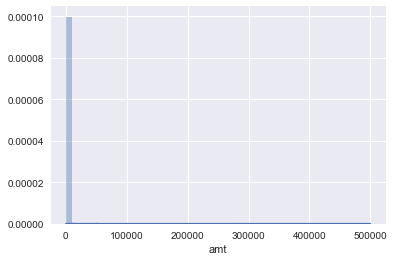

In [37]:
query = """
SELECT transaction_amt AS amt
FROM indiv_sample
WHERE transaction_amt > 0;
"""
result = %sql $query

_ = sns.distplot(result.DataFrame()['amt'])

20158 rows affected.


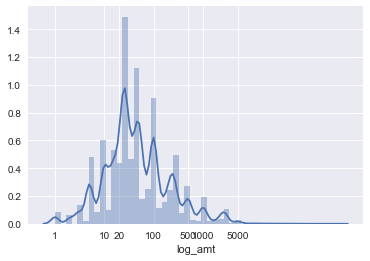

In [38]:
query = """
SELECT LOG(transaction_amt) AS log_amt
FROM indiv_sample
WHERE transaction_amt > 0;
"""
result = %sql  $query
df = result.DataFrame()['log_amt']
sns.distplot(df.astype('float'))
scales = np.array([1, 10, 20,  100, 500,  1000, 5000])
_ = plt.xticks(np.log10(scales), scales)

## Examining the Tail

58 rows affected.


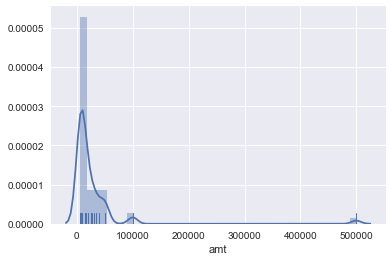

In [39]:
query = """
SELECT transaction_amt AS amt
FROM indiv_sample
WHERE transaction_amt > 5000;
"""
result = %sql  $query

_ = sns.distplot(result.DataFrame()['amt'], rug=True)

60415 rows affected.


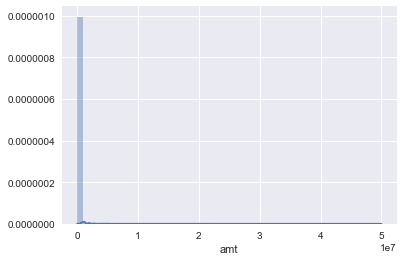

In [40]:
query = """
SELECT transaction_amt AS amt
FROM individual
WHERE transaction_amt > 5000;
"""
result = %sql  $query

_ = sns.distplot(result.DataFrame()['amt'])

60415 rows affected.


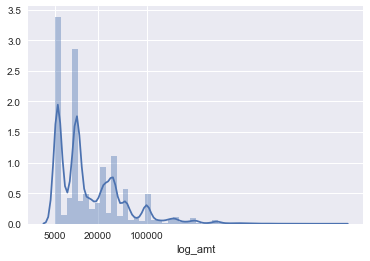

In [41]:
query = """
SELECT log(transaction_amt) AS log_amt
FROM individual
WHERE transaction_amt > 5000;
"""
result = %sql  $query

sns.distplot(result.DataFrame()['log_amt'])
scales = np.array([5000, 20000, 100000])
_ = plt.xticks(np.log10(scales), scales)

290 rows affected.


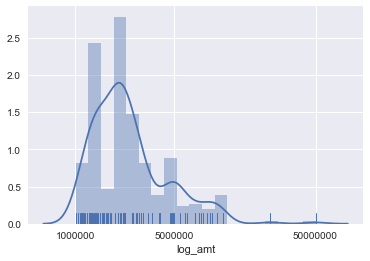

In [42]:
query = """
SELECT log(transaction_amt) AS log_amt
FROM individual
WHERE transaction_amt > 1000000;
"""
result = %sql  $query

sns.distplot(result.DataFrame()['log_amt'], rug=True)
scales = np.array([1000000, 5000000, 50000000])
_ = plt.xticks(np.log10(scales), scales)

#### `CASE` statements: SQL conditionals in the `FROM` clause
What about smaller donations?

In [43]:
# %%sql $postgresql_uri

# SELECT name, state, cmte_id,
#        transaction_amt, LOG(transaction_amt)
# FROM indiv_sample
# WHERE transaction_amt < 10
# LIMIT 10;

Uh oh, log is not defined for numbers <= 0! We need a *conditional* statement in the `select` clause to decide what function to call. We can use SQL's `case` construct for that.

In [44]:
%%sql $postgresql_uri

SELECT name, state, cmte_id, transaction_amt,
    CASE WHEN transaction_amt > 0 THEN log(transaction_amt)
         WHEN transaction_amt = 0 THEN 0
         ELSE -1*(log(abs(transaction_amt)))
    END AS log_magnitude
FROM indiv_sample
WHERE transaction_amt < 10
LIMIT 10;

10 rows affected.


name,state,cmte_id,transaction_amt,log_magnitude
"PHILLIPS, JANE K.",OK,C00513077,5,0.698970004336019
"TURKAL, MICHAEL",OH,C00000885,8,0.903089986991944
"WILTBERGER, ARLENE",CA,C00456335,3,0.477121254719662
"ARLENE HEYMAN M.D., P.C.",NY,C00042366,-250,-2.39794000867204
"HARRIS, RACQUEL L.",AR,C00093054,5,0.698970004336019
"TAYLOR, FLINT MR.",IL,C00342907,1,0.0
"ROSENBERGER, BONNIE J MS.",FL,C00030718,1,0.0
"MATSUZAKA, ETSUKO",None,C00498568,5,0.698970004336019
"MENDEZ-PADELFORD, DIANE M MRS",CA,C00540310,-150,-2.17609125905568
"O'BRIEN, JOAN",IL,C00042366,8,0.903089986991944


2393 rows affected.


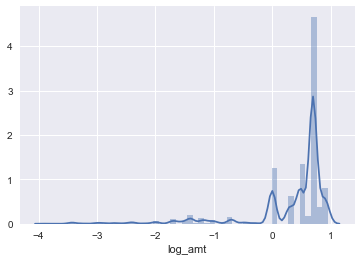

In [45]:
query = """
SELECT transaction_amt,
    CASE WHEN transaction_amt > 0 THEN log(transaction_amt)
         WHEN transaction_amt = 0 THEN 0
         ELSE -1*(log(abs(transaction_amt)))
    END AS log_amt
FROM indiv_sample
WHERE transaction_amt < 10
"""
result = %sql  $query

sns.distplot(result.DataFrame()['log_amt'])
# scales = np.array([1000000, 5000000, 50000000])
# _ = plt.xticks(np.log10(scales), scales)

## Who donated the most?

In [46]:
%%sql

SELECT transaction_amt, cmte_id, transaction_dt, name, city, state, memo_text, occupation 
FROM individual 
ORDER BY transaction_amt DESC
LIMIT 10

10 rows affected.


transaction_amt,cmte_id,transaction_dt,name,city,state,memo_text,occupation
50000000,C00616078,06162016,STATWARE INC. AND OTHER FIRMS,CENTERBOOK,CT,None,None
23787000,C00010603,11072016,HILLARY VICTORY FUND,NEW YORK,NY,None,None
11000000,C00575373,04102015,"MERCER, ROBERT",EAST SETAUKET,NY,None,FINANCE
11000000,C00547349,10262016,"STEYER, THOMAS F.",SAN FRANCISCO,CA,None,FOUNDER
10000000,C00575431,04092015,"NEUGEBAUER, TOBY",DORADO,PR,None,INVESTOR
10000000,C00504530,08292016,"ADELSON, SHELDON",LAS VEGAS,NV,None,CHAIRMAN
10000000,C00571703,08292016,"ADELSON, MIRIAM DR.",LAS VEGAS,NV,None,PHYSICIAN
10000000,C00571703,08262016,"ADELSON, SHELDON G. MR.",LAS VEGAS,NV,None,CHAIRMAN & CEO
10000000,C00571372,10212015,C.V. STARR & CO INC,NEW YORK,NY,None,None
10000000,C00504530,08292016,"ADELSON, MIRIAM",LAS VEGAS,NV,None,PHYSICIAN


## Who was paid the most?

In [47]:
%%sql

SELECT transaction_amt, cmte_id, transaction_dt, name, city, state, memo_text, occupation 
FROM individual 
ORDER BY transaction_amt 
LIMIT 10

10 rows affected.


transaction_amt,cmte_id,transaction_dt,name,city,state,memo_text,occupation
-226800,C00075820,04092015,"ADELSON, MIRIAM O. DR.",LAS VEGAS,NV,REDESIGNATION REQUESTED (AUTOMATIC),PHYSICIAN
-200000,C00618389,10052016,"PEREIRA, ROBERT W.",DELRAY BEACH,FL,None,CHAIRMAN
-129000,C00586537,11152016,"LICHTENSTEIN, DAVID",LAKEWOOD,NJ,NSF/RETURNED CHECK,REAL ESTATE
-121000,C00586537,11152016,"LICHTENSTEIN, SHIFRA",LAKEWOOD,NJ,NSF/RETURNED CHECK,LIFE COACH/ COUNSELOR
-105000,C00592337,04262016,TRUSTED LEADERSHIP PAC,AUSTIN,TX,None,None
-100200,C00075820,09212015,"MERCER, DIANA L. MRS.",EAST SETAUKET,NY,REDESIGNATION TO BUILDING FUND,None
-100200,C00075820,03312015,"FLORES, JAMES C. MR.",HOUSTON,TX,REDESIGNATION TO RECOUNT FUND,CHAIRMAN PRESIDENT AND CEO
-100200,C00075820,03312015,"FLORES, JAMES C. MR.",HOUSTON,TX,REDESIGNATION TO BUILDING FUND,CHAIRMAN PRESIDENT AND CEO
-100200,C00075820,09212015,"MERCER, DIANA L. MRS.",EAST SETAUKET,NY,REDESIGNATION TO RECOUNT FUND,None
-100000,C00586537,10052016,"BAIRD, ALISON LEIGH",LOS ANGELES,CA,NSF/RETURNED CHECK,None


## Grouping Contributions by Name

In [48]:
%%sql

SELECT name, SUM(transaction_amt) AS total_amt
FROM individual 
GROUP BY name
ORDER BY total_amt DESC
LIMIT 10

10 rows affected.


name,total_amt
"STEYER, THOMAS F.",90044644
STATWARE INC. AND OTHER FIRMS,50000000
"EYCHANER, FRED",37921658
HILLARY VICTORY FUND,35379700
NEXTGEN CLIMATE ACTION COMMITTEE,31213354
"ADELSON, MIRIAM",27936800
"SUSSMAN, DONALD",25642400
"SOROS, GEORGE",22364011
SENATE LEADERSHIP FUND,22355200
"BLOOMBERG, MICHAEL R.",21675924


## Going Local with `WHERE`

In [49]:
%%sql 

SELECT name, SUM(transaction_amt) AS total_amt
FROM individual
WHERE city = 'SAN FRANCISCO'
GROUP BY name
ORDER BY total_amt DESC
LIMIT 20;

20 rows affected.


name,total_amt
"STEYER, THOMAS F.",89726944
"MOSKOVITZ, DUSTIN",14111000
"TUNA, CARI",6623000
"SANDLER, HERBERT M.",5494400
"THIEL, PETER",4066700
"OBERNDORF, WILLIAM E. MR.",2416106
"SCHWAB, HELEN O. MRS.",1502700
"OBERNDORF, WILLIAM E.",1371200
WENDT FAMILY TRUST,1350000
AMERICAN PACIFIC INTERNATIONAL CAPITAL INC.,1300000


In [50]:
%%sql 

SELECT name, SUM(transaction_amt) AS total_amt
FROM individual
WHERE city = 'BERKELEY'
GROUP BY name
ORDER BY total_amt DESC
LIMIT 20;

20 rows affected.


name,total_amt
"SHENKER, SCOTT",1334600
"SIMONS, NAT",363400
"SIMONS, NATHANIEL",224700
"WILKINS, MICHAEL IAN",186681
"HEADLEY, MARK",161700
"GUND, LOUISE LAIDLAW",148083
"SLATER, AMY",126340
"HEADLEY, MARK W.",115400
"HEADLEY, MARK W",115200
"BERLEKAMP, ELWYN",114900


# Named Queries: Views and CTEs

Up to now we've looked at a single query at a time. SQL also allows us to nest queries in various ways. In this section we look at the cleaner examples of how to do this in SQL: views and Common Table Expressions (CTEs).

## Views
In earlier examples, we created new tables and populated them from the result of queries over stored tables. There are two main drawbacks of that approach that may concern us in some cases:

1. The new table **uses up storage**, even though it is recomputable from other tables.
1. **Out of date**. The stored output will not reflect changes in the input. 

For this reason, SQL provides a notion of logical *views*: these are basically named queries that are re-evaluated upon each reference. 


The syntax is straightforward:

```sql
CREATE VIEW <name> AS
<SELECT statement>;
```

The resulting view `<name>` can be used in an `SELECT` query, but **not** in an `INSERT`, `DELETE` or `UPDATE` query!

As an example, we might want a view that stores just some summary statistics of `transaction_amt`s for each date:

In [51]:
%%sql $postgresql_uri


DROP VIEW IF EXISTS date_stats;

CREATE VIEW date_stats AS
SELECT 
    transaction_dt AS day,
    min(transaction_amt), 
    avg(transaction_amt), 
    stddev(transaction_amt),
    max(transaction_amt)
FROM individual
GROUP BY transaction_dt
ORDER BY day;

Done.
Done.


[]

In [52]:
%%sql
SELECT * from date_stats limit 5;

5 rows affected.


day,min,avg,stddev,max
01012014,1385,1942.5000000000000000,788.424061023000,2500
01012015,-2600,188.4715555555555556,880.059579180729,30000
01012016,-2700,198.2062088259182384,2545.985242643657,250000
01012017,100,550.0000000000000000,636.396103067893,1000
01022015,-2600,1700.9547432550043516,85215.57949865,5000000


**Notice that this did not create a table: **

In [53]:
!psql ds100 -c "\dt"

             List of relations
 Schema |     Name      | Type  |  Owner   
--------+---------------+-------+----------
 public | boats         | table | jegonzal
 public | ccl           | table | jegonzal
 public | cm            | table | jegonzal
 public | cn            | table | jegonzal
 public | indiv_sample  | table | jegonzal
 public | indiv_sample2 | table | jegonzal
 public | individual    | table | jegonzal
 public | mat_a         | table | jegonzal
 public | my_matrix     | table | jegonzal
 public | oppexp        | table | jegonzal
 public | pas           | table | jegonzal
 public | profs         | table | jegonzal
 public | reserves      | table | jegonzal
 public | sailors       | table | jegonzal
 public | students      | table | jegonzal
 public | tips          | table | jegonzal
(16 rows)



**Instead it created a view:**

In [54]:
!psql ds100 -c "\dv"

           List of relations
 Schema |    Name    | Type |  Owner   
--------+------------+------+----------
 public | date_stats | view | jegonzal
 public | rando      | view | jegonzal
(2 rows)



We can list more about the view using the `\d+` option:

In [55]:
!psql ds100 -c "\d+ date_stats"

                      View "public.date_stats"
 Column |         Type         | Modifiers | Storage  | Description 
--------+----------------------+-----------+----------+-------------
 day    | character varying(9) |           | extended | 
 min    | integer              |           | plain    | 
 avg    | numeric              |           | main     | 
 stddev | numeric              |           | main     | 
 max    | integer              |           | plain    | 
View definition:
 SELECT individual.transaction_dt AS day,
    min(individual.transaction_amt) AS min,
    avg(individual.transaction_amt) AS avg,
    stddev(individual.transaction_amt) AS stddev,
    max(individual.transaction_amt) AS max
   FROM individual
  GROUP BY individual.transaction_dt
  ORDER BY individual.transaction_dt;



### Views are not materialized

Let's create a random table and we will even seed the random number generator.

In [56]:
%%sql $postgresql_uri

SELECT setseed(0.3);

DROP VIEW IF EXISTS rando;

CREATE VIEW rando(rownum, rnd) AS
SELECT rownum, round(random())::INTEGER
FROM generate_series(1,50) AS ind(rownum)

1 rows affected.
Done.
Done.


[]

What is the sum of the rows in Random:

In [57]:
%%sql $postgresql_uri

SELECT SUM(rnd) FROM rando;

1 rows affected.


sum
19


What was that value again?


In [58]:
%%sql $postgresql_uri

SELECT SUM(rnd) FROM rando;

1 rows affected.


sum
26


--- 
</br></br></br>

The value changes with each invocation.

## Too Many Views

Views can help:
* Simplify queries
* Make complex queries more readable 
* Share "sql programs" with others 

Problem:
* Creating a new view for each (exploratory) query will result in a lot of views! 
* views like: `temp1`, `temp1_joey`, `temp1_joey_fixed`, ... 

** We need a mechanism to decompose query into views for the scope of a single query.**

## Common Table Expressions (`WITH`)

Think of these as a view that exists only during the query.

If we're only going to use a view within a single query, it is a little inelegant to `CREATE` it, and then have to `DROP` it later to recycle the view name.

*Common Table Expressions* (CTEs) are like views that we use on-the-fly. (If you know about lambdas in Python, you can think of CTEs as lambda views.) The syntax for CTEs is to use a `WITH` clause in front of the query: 

`WITH <name> [(renamed columns)] AS 
  (<SELECT statement>) 
  [, <name2> AS (<SELECT statement>)...]`

If you need multiple CTEs, you separate them with commas.
We can rewrite our query above without a view as follows:

In [59]:
%%sql $postgresql_uri

WITH per_day_stats AS (
    SELECT 
        to_date(transaction_dt, 'MMDDYYYY') as day, -- Date Parsing
        min(transaction_amt), 
        avg(transaction_amt), 
        stddev(transaction_amt),
        max(transaction_amt)
    FROM indiv_sample
    GROUP BY transaction_dt
)    
SELECT day, stddev, max - min AS spread
FROM per_day_stats
WHERE stddev IS NOT NULL
ORDER by stddev DESC
LIMIT 5

5 rows affected.


day,stddev,spread
2015-01-29,156888.68706687,499975
2016-03-07,25722.24049839,100003
2015-02-12,20132.91934867,49998
2015-04-28,11091.96653113,33390
2016-07-13,10412.93231550,49995


# Joins

Suppose now we want to determine which committees received the most money

In [60]:
%%sql $postgresql_uri

SELECT cmte_id, SUM(transaction_amt) AS total_amt
FROM individual 
GROUP BY cmte_id
ORDER BY total_amt DESC
LIMIT 10

10 rows affected.


cmte_id,total_amt
C00586537,428422747
C00401224,314682670
C00575795,293602014
C00495861,183763164
C00571372,132142087
C00003418,123195123
C00618389,107943772
C00571703,104275579
C00547349,92536032
C00010603,89932788


## What are the names of these Committees?

In [61]:
!psql ds100 -c "\d"

             List of relations
 Schema |     Name      | Type  |  Owner   
--------+---------------+-------+----------
 public | boats         | table | jegonzal
 public | ccl           | table | jegonzal
 public | cm            | table | jegonzal
 public | cn            | table | jegonzal
 public | date_stats    | view  | jegonzal
 public | indiv_sample  | table | jegonzal
 public | indiv_sample2 | table | jegonzal
 public | individual    | table | jegonzal
 public | mat_a         | table | jegonzal
 public | my_matrix     | table | jegonzal
 public | oppexp        | table | jegonzal
 public | pas           | table | jegonzal
 public | profs         | table | jegonzal
 public | rando         | view  | jegonzal
 public | reserves      | table | jegonzal
 public | sailors       | table | jegonzal
 public | students      | table | jegonzal
 public | tips          | table | jegonzal
(18 rows)



In [62]:
!psql ds100 -c "\d cm"

                               Table "public.cm"
        Column        |         Type          |            Modifiers            
----------------------+-----------------------+---------------------------------
 cmte_id              | character varying(9)  | 
 cmte_nm              | text                  | 
 tres_nm              | text                  | 
 cmte_st1             | text                  | 
 cmte_st2             | text                  | 
 cmte_city            | text                  | 
 cmte_st              | character varying(2)  | 
 cmte_zip             | character varying(10) | 
 cmte_dsgn            | character(1)          | 
 cmte_tp              | character(1)          | 
 cmte_pty_affiliation | character varying(3)  | 
 cmte_filing_freq     | character(1)          | 
 org_tp               | character(1)          | 
 connected_org_nm     | text                  | 
 cand_id              | character varying(9)  | default NULL::character varying



We can join the committee description to get the names of the committees that received the most funds. 

In [63]:
%%sql $postgresql_uri

WITH indv2cm AS
(
    SELECT cmte_id, SUM(transaction_amt) AS total_amt
    FROM individual
    GROUP BY cmte_id
    ORDER BY total_amt DESC
)
SELECT cm.cmte_nm, indv2cm.total_amt 
FROM cm, indv2cm
WHERE cm.cmte_id = indv2cm.cmte_id
ORDER BY indv2cm.total_amt DESC
LIMIT 10

10 rows affected.


cmte_nm,total_amt
HILLARY VICTORY FUND,428422747
ACTBLUE,314682670
HILLARY FOR AMERICA,293602014
PRIORITIES USA ACTION,183763164
RIGHT TO RISE USA,132142087
REPUBLICAN NATIONAL COMMITTEE,123195123
TRUMP VICTORY,107943772
SENATE LEADERSHIP FUND,104275579
NEXTGEN CLIMATE ACTION COMMITTEE,92536032
DNC SERVICES CORP./DEM. NAT'L COMMITTEE,89932788


## Which candidate received the most

In [64]:
!psql ds100 -c "\d"

             List of relations
 Schema |     Name      | Type  |  Owner   
--------+---------------+-------+----------
 public | boats         | table | jegonzal
 public | ccl           | table | jegonzal
 public | cm            | table | jegonzal
 public | cn            | table | jegonzal
 public | date_stats    | view  | jegonzal
 public | indiv_sample  | table | jegonzal
 public | indiv_sample2 | table | jegonzal
 public | individual    | table | jegonzal
 public | mat_a         | table | jegonzal
 public | my_matrix     | table | jegonzal
 public | oppexp        | table | jegonzal
 public | pas           | table | jegonzal
 public | profs         | table | jegonzal
 public | rando         | view  | jegonzal
 public | reserves      | table | jegonzal
 public | sailors       | table | jegonzal
 public | students      | table | jegonzal
 public | tips          | table | jegonzal
(18 rows)



### Candidate Name Table

In [65]:
!psql ds100 -c "\d cn"

                    Table "public.cn"
        Column        |         Type          | Modifiers 
----------------------+-----------------------+-----------
 cand_id              | character varying(9)  | 
 cand_name            | text                  | 
 cand_pty_affiliation | character varying(3)  | 
 cand_election_yr     | integer               | 
 cand_office_st       | character varying(2)  | 
 cand_office          | character(1)          | 
 cand_office_district | integer               | 
 cand_ici             | character(1)          | 
 cand_status          | character(1)          | 
 cand_pcc             | character varying(9)  | 
 cand_st1             | text                  | 
 cand_st2             | text                  | 
 cand_city            | text                  | 
 cand_st              | character varying(2)  | 
 cand_zip             | character varying(10) | 



### Candidate Committee Linkage Table

In [66]:
!psql ds100 -c "\d ccl"

                 Table "public.ccl"
      Column      |         Type         | Modifiers 
------------------+----------------------+-----------
 cand_id          | character varying(9) | 
 cand_election_yr | integer              | 
 fec_election_yr  | integer              | 
 cmte_id          | character varying(9) | 
 cmte_tp          | character(1)         | 
 cmte_dsgn        | character(1)         | 
 linkage_id       | integer              | 



### Joining Aggregated Indiv - CCL - CN

In [67]:
%%sql 
SELECT cn.cand_name, SUM(indiv.transaction_amt) AS total_amt
FROM individual AS indiv, ccl, cn
WHERE indiv.cmte_id = ccl.cmte_id AND
    ccl.cand_id = cn.cand_id 
GROUP BY cn.cand_name
ORDER BY total_amt DESC
LIMIT 10



10 rows affected.


cand_name,total_amt
"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",293602014
"SANDERS, BERNARD",84741223
"TRUMP, DONALD J. / MICHAEL R. PENCE",65329708
"RUBIO, MARCO",60770391
"RYAN, PAUL D.",58792561
"CRUZ, RAFAEL EDWARD ""TED""",54016803
"BUSH, JEB",33215298
"CARSON, BENJAMIN S SR MD",27720768
"VAN HOLLEN, CHRIS",27254529
"PORTMAN, ROB",21122605


### Localized Join for CA

In [68]:
%%sql 

SELECT cn.cand_name, SUM(indiv.transaction_amt) AS total_amt
FROM individual AS indiv, ccl, cn
WHERE indiv.cmte_id = ccl.cmte_id AND
    ccl.cand_id = cn.cand_id AND
    indiv.state = 'CA'
GROUP BY cn.cand_name
ORDER BY total_amt DESC
LIMIT 10

10 rows affected.


cand_name,total_amt
"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",64312114
"SANDERS, BERNARD",18755158
"HARRIS, KAMALA D",9217342
"RUBIO, MARCO",8290342
"MCCARTHY, KEVIN",5885992
"CRUZ, RAFAEL EDWARD ""TED""",5477703
"RYAN, PAUL D.",5419340
"TRUMP, DONALD J. / MICHAEL R. PENCE",5183688
"MASTO, CATHERINE CORTEZ",3405938
"BUSH, JEB",3356045


### Localized Join for FL

In [69]:
%%sql 
SELECT cn.cand_name, SUM(indiv.transaction_amt) AS total_amt
FROM individual AS indiv, ccl, cn
WHERE indiv.cmte_id = ccl.cmte_id AND
    ccl.cand_id = cn.cand_id AND
    indiv.state = 'FL'
GROUP BY cn.cand_name
ORDER BY total_amt DESC
LIMIT 10

10 rows affected.


cand_name,total_amt
"RUBIO, MARCO",17355941
"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",15315796
"PERKINS, RANDY",10315395
"MURPHY, PATRICK E",7926526
"BUSH, JEB",7291164
"RYAN, PAUL D.",6129278
"TRUMP, DONALD J. / MICHAEL R. PENCE",5072826
"ROONEY, FRANCIS",4280801
"SANDERS, BERNARD",3053688
"CRUZ, RAFAEL EDWARD ""TED""",2741375


### Localized Join for TX

In [70]:
%%sql 
SELECT cn.cand_name, SUM(indiv.transaction_amt) AS total_amt
FROM individual AS indiv, ccl, cn
WHERE indiv.cmte_id = ccl.cmte_id AND
    ccl.cand_id = cn.cand_id AND
    indiv.state = 'TX'
GROUP BY cn.cand_name
ORDER BY total_amt DESC
LIMIT 10

10 rows affected.


cand_name,total_amt
"CRUZ, RAFAEL EDWARD ""TED""",20464749
"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",16124458
"RYAN, PAUL D.",7905676
"TRUMP, DONALD J. / MICHAEL R. PENCE",5763918
"RUBIO, MARCO",4998601
"BUSH, JEB",3904580
"CRUZ, RAFAEL EDWARD TED",3310330
"CARSON, BENJAMIN S SR MD",3291938
"SANDERS, BERNARD",3135692
"DEWHURST, DAVID H",2501335


## Tracking Direct Committee Contributions

In [71]:
%%sql 

SELECT cm.cmte_nm, SUM(transaction_amt) AS total_amt
FROM pas, cm
WHERE pas.cmte_id = cm.cmte_id
GROUP BY cm.cmte_nm
ORDER BY total_amt DESC
LIMIT 5

5 rows affected.


cmte_nm,total_amt
PRIORITIES USA ACTION,133443133
DSCC,118795008
RIGHT TO RISE USA,86817138
SENATE LEADERSHIP FUND,85994270
DCCC,84368850


In [72]:
%%sql 

SELECT cn.cand_name, SUM(transaction_amt) AS total_amt
FROM pas, cn
WHERE pas.cand_id = cn.cand_id
GROUP BY cn.cand_name
ORDER BY total_amt DESC
LIMIT 5

5 rows affected.


cand_name,total_amt
"TRUMP, DONALD J. / MICHAEL R. PENCE",322303387
"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",191839266
"BUSH, JEB",87255752
"TOOMEY, PATRICK JOSEPH",73347997
"AYOTTE, KELLY A",64513126
